In [1]:
# The gp_sfh.py file contains a simple GP framework that we'll be using
from gp_sfh import *
from gp_sfh_kernels import *

#--------------------------------------------------------------------------------------
# import FSPS and set up a fiducial set of parameters (dust, metallicity, IMF, etc.)
#--------------------------------------------------------------------------------------

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

from copy import deepcopy
import pickle

import fsps
sp = fsps.StellarPopulation(imf_type=2, zcontinuous=1)
sp.params['imf_type'] = 1 # Chabrier
sp.params['logzsol'] = 0.0 # Solar metallicity
sp.params['dust_type'] = 2 # Calzetti
sp.params['dust2'] = 0.2
sp.params['sfh'] = 3
sp.params['add_neb_emission'] = True
sp.params['add_neb_continuum'] = True

import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style('white')
import pandas as pd
import corner

/home/iyer/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
sig_reg = np.sqrt(0.97) * (0.4)
sig_dyn = np.sqrt(0.03) * (0.4)
kernel_params_MW_1dex = [sig_reg, 2500/1e3, 150/1e3, sig_dyn, 25/1e3]
kernel_params_dwarf_1dex = [sig_reg, 30/1e3, 150/1e3, sig_dyn, 10/1e3]
kernel_params_noon_1dex = [sig_reg, 200/1e3, 100/1e3, sig_dyn, 50/1e3]
kernel_params_highz_1dex = [sig_reg, 15/1e3, 16/1e3, sig_dyn, 6/1e3]
print('using $\sigma_{reg}: %.4f$, $\sigma_{dyn}: %.4f$. ' %(sig_reg, sig_dyn))

TCF20_scattervals = [0.17, 0.53, 0.24, 0.27]
# regnorm = ((1)**2 + (0.03)**2)
regnorm = 0.4**2
kernel_params_MW_TCF20 = [sig_reg * np.sqrt(TCF20_scattervals[0]**2/regnorm), 
                          2500/1e3, 150/1e3, 
                          sig_dyn * np.sqrt(TCF20_scattervals[0]**2/regnorm), 
                          25/1e3]
kernel_params_dwarf_TCF20 = [sig_reg * np.sqrt(TCF20_scattervals[1]**2/regnorm), 30/1e3, 150/1e3, sig_dyn * np.sqrt(TCF20_scattervals[1]**2/regnorm), 10/1e3]
kernel_params_noon_TCF20 = [sig_reg * np.sqrt(TCF20_scattervals[2]**2/regnorm), 200/1e3, 100/1e3, sig_dyn * np.sqrt(TCF20_scattervals[2]**2/regnorm), 50/1e3]
kernel_params_highz_TCF20 = [sig_reg * np.sqrt(TCF20_scattervals[3]**2/regnorm), 15/1e3, 16/1e3, sig_dyn * np.sqrt(TCF20_scattervals[3]**2/regnorm), 6/1e3]

using $\sigma_{reg}: 0.3940$, $\sigma_{dyn}: 0.0693$. 


MW \sigma_eff = sqrt(C(\tau=0)): 0.4000000 dex
dwarf \sigma_eff = sqrt(C(\tau=0)): 0.4000000 dex
noon \sigma_eff = sqrt(C(\tau=0)): 0.4000000 dex
highz \sigma_eff = sqrt(C(\tau=0)): 0.4000000 dex


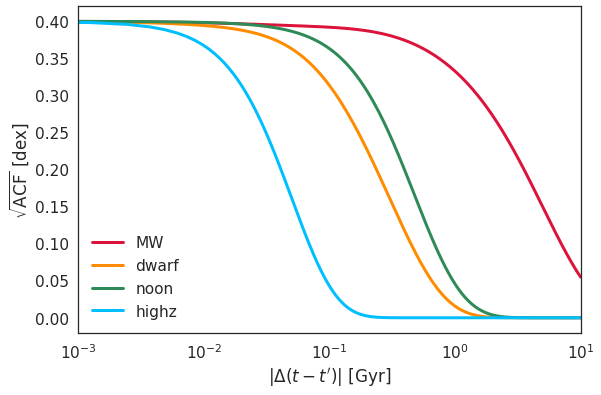

MW \sigma_eff = sqrt(C(\tau=0)): 0.1700 dex
dwarf \sigma_eff = sqrt(C(\tau=0)): 0.5300 dex
noon \sigma_eff = sqrt(C(\tau=0)): 0.2400 dex
highz \sigma_eff = sqrt(C(\tau=0)): 0.2700 dex


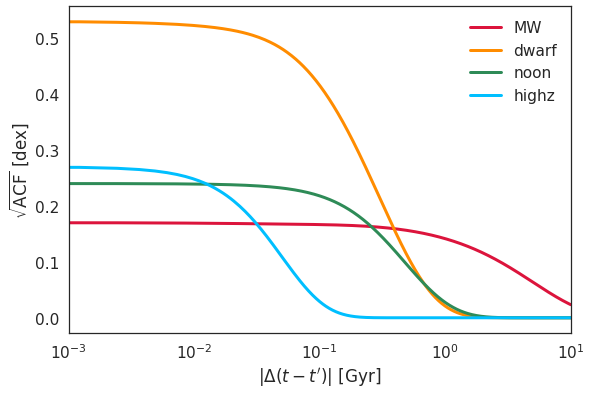

In [3]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_1dex, kernel_params_dwarf_1dex, kernel_params_noon_1dex, kernel_params_highz_1dex]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

plt.figure(figsize=(9,6))

for i, case in enumerate(cases):

    deltat = np.linspace(0,cosmo.age(zval).value,tarr_res)
    temp = extended_regulator_model_kernel_paramlist(deltat, case_params[i])
    plt.plot(deltat, np.sqrt(temp),lw=3,label=case,color=case_colors[i])
    
    print(case+r' \sigma_eff = sqrt(C(\tau=0)): %.7f dex' %(np.sqrt(extended_regulator_model_kernel_paramlist(deltat, case_params[i])[0])))
    
plt.legend(edgecolor='w')
plt.xscale('log');
plt.xlim(1e-3,1e1)
plt.xlabel('$|\Delta (t-t\')|$ [Gyr]')
plt.ylabel(r'$\sqrt{\rm ACF}$ [dex]')
plt.show()
    
    
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_TCF20, kernel_params_dwarf_TCF20, kernel_params_noon_TCF20, kernel_params_highz_TCF20]


plt.figure(figsize=(9,6))

for i, case in enumerate(cases):
    
    deltat = np.linspace(0,cosmo.age(zval).value,tarr_res)
    temp = extended_regulator_model_kernel_paramlist(deltat, case_params[i])
    plt.plot(deltat, np.sqrt(temp),lw=3,label=case,color=case_colors[i])
   
    print(case+r' \sigma_eff = sqrt(C(\tau=0)): %.4f dex' %(np.sqrt(extended_regulator_model_kernel_paramlist(deltat, case_params[i])[0])))
    
plt.legend(edgecolor='w')
plt.xscale('log');
plt.xlim(1e-3,1e1)
plt.xlabel('$|\Delta (t-t\')|$ [Gyr]')
plt.ylabel(r'$\sqrt{\rm ACF}$ [dex]')
plt.show()
    

In [4]:
nsamp = 10000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_1dex, kernel_params_dwarf_1dex, kernel_params_noon_1dex, kernel_params_highz_1dex]

for i, case in enumerate(cases):
    
    case1 = simple_GP_sfh(sp=sp, cosmo=cosmo, zval = zval)
    case1.get_tarr(n_tarr = tarr_res)
    #case1.get_basesfh(sfhtype='MS', mstar = 10.0)
    case1.get_basesfh(sfhtype='const')
    case1.kernel = extended_regulator_model_kernel_paramlist


    case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, 
                                        force_cov=True, kernel_params = case_params[i])
    
    case1.get_spec(nsamp = nsamp)
    case1.calc_spectral_features(massnorm = True)
    
    fname = '/media/iyer/storage_main/GP-SFH-big-kernels/v2_ExReg_1dex_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.pkl' %(tarr_res, zval, nsamp, random_seed)
    with open(fname, 'wb') as fil:
        pickle.dump(case1, fil)

100%|█████████████████████████████████████| 10000/10000 [07:17<00:00, 22.86it/s]


In [5]:
nsamp = 10000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_TCF20, kernel_params_dwarf_TCF20, kernel_params_noon_TCF20, kernel_params_highz_TCF20]

for i, case in enumerate(cases):
    
    case1 = simple_GP_sfh(sp=sp, cosmo=cosmo, zval = zval)
    case1.get_tarr(n_tarr = tarr_res)
    #case1.get_basesfh(sfhtype='MS', mstar = 10.0)
    case1.get_basesfh(sfhtype='const')
    case1.kernel = extended_regulator_model_kernel_paramlist


    case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, 
                                        force_cov=True, kernel_params = case_params[i])
    
    case1.get_spec(nsamp = nsamp)
    case1.calc_spectral_features(massnorm = True)
    
    fname = '/media/iyer/storage_main/GP-SFH-big-kernels/v2_ExReg_TCF20_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.pkl' %(tarr_res, zval, nsamp, random_seed)
    with open(fname, 'wb') as fil:
        pickle.dump(case1, fil)

100%|█████████████████████████████████████| 10000/10000 [07:19<00:00, 22.78it/s]


# precompute models with additional scaled scatter

In [6]:
def get_sigma_GMC_scale(sigma=1.0, tau_eq = 1.0, tau_in = 0.5, sigma_gmc = 0.01, tau_gmc = 0.001):
    """
    function to calculate relative GMC burstiness factoring in timescale effects
    """
    
    C0_norm_reg = sigma**2 / (tau_in + tau_eq)
    C0_norm_gmc = sigma_gmc**2 / (2*tau_gmc)
    
    effective_sigma_gmc_ratio = np.sqrt(C0_norm_gmc / C0_norm_reg)
    
    return effective_sigma_gmc_ratio
    

kernel_norm = 0.3 # in dex    
TCF20_scattervals = [0.17, 0.53, 0.24, 0.27]
    
kernel_params_MW_1dex = [1.0*kernel_norm, 2500/1e3, 150/1e3, 0.03*kernel_norm, 25/1e3]
rel_gmc = get_sigma_GMC_scale(*kernel_params_MW_1dex); print(rel_gmc)
kernel_params_MW_1dex_rel_gmc = [1.0*kernel_norm, 2500/1e3, 150/1e3, rel_gmc*kernel_norm, 25/1e3]
kernel_params_MW_TCF20_rel_gmc = [np.sqrt(TCF20_scattervals[0]**2/(1 + (rel_gmc)**2)), 2500/1e3, 150/1e3, rel_gmc*np.sqrt(TCF20_scattervals[0]**2/(1 + (rel_gmc)**2)), 25/1e3]

kernel_params_dwarf_1dex = [1.0*kernel_norm, 30/1e3, 150/1e3, 0.03*kernel_norm, 10/1e3]
rel_gmc = get_sigma_GMC_scale(*kernel_params_dwarf_1dex); print(rel_gmc)
kernel_params_dwarf_1dex_rel_gmc = [1.0*kernel_norm, 2500/1e3, 150/1e3, rel_gmc*kernel_norm, 25/1e3]
kernel_params_dwarf_TCF20_rel_gmc = [np.sqrt(TCF20_scattervals[1]**2/(1 + (rel_gmc)**2)), 30/1e3, 150/1e3, rel_gmc*np.sqrt(TCF20_scattervals[1]**2/(1 + (rel_gmc)**2)), 10/1e3]

kernel_params_noon_1dex = [1.0*kernel_norm, 200/1e3, 100/1e3, 0.03*kernel_norm, 50/1e3]
rel_gmc = get_sigma_GMC_scale(*kernel_params_noon_1dex); print(rel_gmc)
kernel_params_noon_1dex_rel_gmc = [1.0*kernel_norm, 2500/1e3, 150/1e3, rel_gmc*kernel_norm, 25/1e3]
kernel_params_noon_TCF20_rel_gmc = [np.sqrt(TCF20_scattervals[2]**2/(1 + (rel_gmc)**2)), 200/1e3, 100/1e3, rel_gmc*np.sqrt(TCF20_scattervals[2]**2/(1 + (rel_gmc)**2)), 50/1e3]

kernel_params_highz_1dex = [1.0*kernel_norm, 15/1e3, 16/1e3, 0.03*kernel_norm, 6/1e3]
rel_gmc = get_sigma_GMC_scale(*kernel_params_highz_1dex); print(rel_gmc)
kernel_params_highz_1dex_rel_gmc = [1.0*kernel_norm, 2500/1e3, 150/1e3, rel_gmc*kernel_norm, 25/1e3]
kernel_params_highz_TCF20_rel_gmc = [np.sqrt(TCF20_scattervals[3]**2/(1 + (rel_gmc)**2)), 15/1e3, 16/1e3, rel_gmc*np.sqrt(TCF20_scattervals[3]**2/(1 + (rel_gmc)**2)), 6/1e3]

0.21840329667841554
0.09
0.05196152422706632
0.04821825380496477


In [7]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_1dex_rel_gmc, kernel_params_dwarf_1dex_rel_gmc, kernel_params_noon_1dex_rel_gmc, kernel_params_highz_1dex_rel_gmc]

for i, case in enumerate(cases):
    
    case1 = simple_GP_sfh(sp=sp, cosmo=cosmo, zval = zval)
    case1.get_tarr(n_tarr = tarr_res)
    #case1.get_basesfh(sfhtype='MS', mstar = 10.0)
    case1.get_basesfh(sfhtype='const')
    case1.kernel = extended_regulator_model_kernel_paramlist


    case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, 
                                        force_cov=True, kernel_params = case_params[i])
    
    case1.get_spec(nsamp = nsamp)
    case1.calc_spectral_features(massnorm = True)
    
    fname = '/media/iyer/storage_main/GP-SFH-big-kernels/v2_ExReg_1dex_rel_gmc_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.pkl' %(tarr_res, zval, nsamp, random_seed)
    with open(fname, 'wb') as fil:
        pickle.dump(case1, fil)

100%|█████████████████████████████████████| 10000/10000 [06:55<00:00, 24.06it/s]


In [8]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_TCF20_rel_gmc, kernel_params_dwarf_TCF20_rel_gmc, kernel_params_noon_TCF20_rel_gmc, kernel_params_highz_TCF20_rel_gmc]

for i, case in enumerate(cases):
    
    case1 = simple_GP_sfh(sp=sp, cosmo=cosmo, zval = zval)
    case1.get_tarr(n_tarr = tarr_res)
    #case1.get_basesfh(sfhtype='MS', mstar = 10.0)
    case1.get_basesfh(sfhtype='const')
    case1.kernel = extended_regulator_model_kernel_paramlist


    case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, 
                                        force_cov=True, kernel_params = case_params[i])
    
    case1.get_spec(nsamp = nsamp)
    case1.calc_spectral_features(massnorm = True)
    
    fname = '/media/iyer/storage_main/GP-SFH-big-kernels/v2_ExReg_TCF20_rel_gmc_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.pkl' %(tarr_res, zval, nsamp, random_seed)
    with open(fname, 'wb') as fil:
        pickle.dump(case1, fil)

100%|█████████████████████████████████████| 10000/10000 [07:20<00:00, 22.70it/s]
